In [33]:
!pip install yfinance
!pip install talib-binary
!pip install python-binance

You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.


In [5]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/crypto-prediction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/crypto-prediction")
else:
    repo_path = Path("/home/matias/crypto-prediction")
sys.path.append(str(repo_path))

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import talib
import tensorflow as tf
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.models import Model
from torch.utils.data import DataLoader, Dataset, TensorDataset
from wandb.keras import WandbCallback

import get_data
import wandb
from tools import inspect_code, plotting, training, wandb_api

log_wandb = True
tf.config.list_physical_devices("CPU")[0].device_type


ModuleNotFoundError: No module named 'tensorflow'

In [3]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="crypto-prediction",
        group="Initial Gan",
        job_type="test",
    )


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: matiasetcheverry (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/matias/.netrc
2022-03-25 09:19:40.847971: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 09:19:40.848041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["log_wandb"] = False
config["train_val_test_split"] = [0.7, 0.15, 0.15]
config["nb_previous_close"] = 50
config["batch_size"] = 128
config["n_discriminator"] = 5
config["gp_weight"] = 10
config["learning_rate_generator"] = 0.0001
config["learning_rate_discriminator"] = 0.0004
config["beta1"] = 0.5
config["beta2"] = 0.9


In [5]:
def concatenate_indicators(data):
    differences = data.diff(periods=1, axis=0).rename(
        columns={
            "Open": "Opend",
            "High": "Highd",
            "Low": "Lowd",
            "Close": "Closed",
            "Volume": "Volumed",
        }
    )
    pct_changes = data.pct_change(periods=1, axis=0).rename(
        columns={
            "Open": "Openp",
            "High": "Highp",
            "Low": "Lowp",
            "Close": "Closep",
            "Volume": "Volumep",
        }
    )
    SMA5 = talib.SMA(data["Close"], timeperiod=5)
    SMA10 = talib.SMA(data["Close"], timeperiod=10)
    SMA20 = talib.SMA(data["Close"], timeperiod=20)
    EMA12 = talib.EMA(data["Close"], timeperiod=12)
    EMA26 = talib.EMA(data["Close"], timeperiod=26)
    MACD, MACDsign, _ = talib.MACD(
        data["Close"], fastperiod=12, slowperiod=26, signalperiod=9
    )
    ROC13 = talib.ROC(data["Close"], timeperiod=13)
    K15, D5 = talib.STOCHF(
        data["High"],
        data["Low"],
        data["Close"],
        fastk_period=15,
        fastd_period=5,
        fastd_matype=0,
    )
    BOLup, _, BOLlow = talib.BBANDS(
        data["Close"], timeperiod=5, nbdevup=2, nbdevdn=2, matype=0
    )
    BOL = (data["Close"] - BOLlow) / (BOLup - BOLlow)
    MOM12 = talib.MOM(data["Close"], timeperiod=12)
    indicators = {
        "SMA5": SMA5,
        "SMA10": SMA10,
        "SMA20": SMA20,
        "EMA12": EMA12,
        "EMA26": EMA26,
        "MACD": MACD,
        "MACDsign": MACDsign,
        "ROC13": ROC13,
        "K15": K15,
        "D5": D5,
        "BOLup": BOLup,
        "BOLlow": BOLlow,
        "BOL": BOL,
        "MOM12": MOM12,
    }
    indicators_df = pd.concat(
        indicators.values(),
        axis=1,
        keys=indicators.keys(),
    )
    klines = pd.concat([data, differences, pct_changes, indicators_df], axis=1)
    return klines


In [6]:
class DataModule:
    def __init__(
        self,
        config,
        csv_file=None,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config

        if csv_file is not None:
            self.df = pd.read_csv(csv_file, delimiter=";")
            self.df["BEGINNING_DATE"] = pd.to_datetime(
                self.df["BEGINNING_DATE"], dayfirst=True
            )
            self.df["ENDING_DATE"] = pd.to_datetime(
                self.df["ENDING_DATE"], dayfirst=True
            )

        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

    def _preprocess_klines(
        self,
        data=None,
        ticker=None,
        beginning_date=None,
        ending_date=None,
        interval="6h",
    ):
        if data is None:
            try:
                data = get_data.select_data(
                    ticker,
                    interval,
                    #                 beginning_date = datetime.today() - timedelta(days=59),
                    #                 ending_date= datetime.today()
                    beginning_date=beginning_date,
                    ending_date=ending_date,
                    compute_metrics=concatenate_indicators,
                    directory="./wgan-gp",
                )
            except Exception:
                print(f"Ticker {ticker} could not be downloaded")
                return None, [], [], []
        data = data.dropna(axis=0)
        if data.empty:
            print(f"Ticker {ticker} could not be downloaded")
            return None, [], [], []
        data = data.drop(labels="Datetime", axis=1)
        data = data.replace(
            to_replace=[np.inf, -np.inf, np.float64("inf"), -np.float64("inf")],
            value=0,
        )
        idx_close = list(data.columns).index("Close")
        scaler = MinMaxScaler(feature_range=(-1, 1))
        klines = tf.convert_to_tensor(scaler.fit_transform(data), dtype=tf.float32)
        data_close = klines[:, idx_close]
        single_close = tf.convert_to_tensor(
            data_close[self.config["nb_previous_close"] :]
        )
        multiple_close = tf.stack(
            [
                data_close[i : i + self.config["nb_previous_close"]]
                for i in range(len(data_close) - self.config["nb_previous_close"])
            ]
        )
        multiple_klines = tf.stack(
            [
                klines[i : i + self.config["nb_previous_close"], :]
                for i in range(len(klines) - self.config["nb_previous_close"])
            ]
        )

        close_scaler = MinMaxScaler(feature_range=(-1, 1))
        close_scaler.fit(data["Close"].to_numpy().reshape(-1, 1))
        return close_scaler, multiple_klines, single_close, multiple_close

    def setup(self):
        klines = []
        single_closes = []
        multiple_closes = []

        scalers = []
        test_klines = []
        test_single_closes = []
        test_multiple_closes = []
        for index, row in self.df.iterrows():
            scaler, kline, single_close, multiple_close = self._preprocess_klines(
                ticker=row["TICKER"],
                beginning_date=row["BEGINNING_DATE"],
                ending_date=row["ENDING_DATE"],
            )
            if len(kline) > 0:
                n = int(len(kline) * (1 - self.config["train_val_test_split"][-1]))
                klines.append(kline[:n])
                single_closes.append(single_close[:n])
                multiple_closes.append(multiple_close[:n])

                test_klines.append(tf.data.Dataset.from_tensor_slices(kline[n:]))
                test_single_closes.append(
                    tf.data.Dataset.from_tensor_slices(
                        tf.expand_dims(
                            (tf.expand_dims(single_close[n:], axis=-1)), axis=-1
                        ),
                    )
                )
                test_multiple_closes.append(
                    tf.data.Dataset.from_tensor_slices(
                        tf.expand_dims(multiple_close[n:], axis=-1),
                    )
                )
                scalers.append(scaler)

        klines = tf.data.Dataset.from_tensor_slices(
            tf.concat(klines, axis=0),
        )
        single_closes = tf.data.Dataset.from_tensor_slices(
            tf.expand_dims(
                (tf.expand_dims(tf.concat(single_closes, axis=0), axis=-1)), axis=-1
            ),
        )
        multiple_closes = tf.data.Dataset.from_tensor_slices(
            tf.expand_dims(tf.concat(multiple_closes, axis=0), axis=-1),
        )
        dataset = (
            tf.data.Dataset.zip((klines, multiple_closes, single_closes))
            .shuffle(len(klines), reshuffle_each_iteration=True)
            .batch(
                self.config["batch_size"],
                drop_remainder=False,
                num_parallel_calls=tf.data.AUTOTUNE,
            )
        )
        self.test_datasets = [
            (
                scaler,
                tf.data.Dataset.zip((kline, multiple_close, single_close)).batch(
                    self.config["batch_size"],
                    drop_remainder=False,
                    num_parallel_calls=tf.data.AUTOTUNE,
                ),
            )
            for scaler, kline, multiple_close, single_close in zip(
                scalers, test_klines, test_multiple_closes, test_single_closes
            )
        ]

        train_size = int(
            config["train_val_test_split"][0]
            / (1 - self.config["train_val_test_split"][-1])
            * len(dataset)
        )
        self.train_dataset = dataset.take(train_size)
        self.val_dataset = dataset.skip(train_size)


dm = DataModule(config, repo_path / "DATE.csv")
dm.setup()
train_dataset = dm.train_dataset
test_datasets = dm.test_datasets
print(len(test_datasets))


[*********************100%***********************]  1 of 1 completed


2022-03-25 09:19:54.964085: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

2022-03-25 09:22:16.015295: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 305027800 exceeds 10% of free system memory.


In [9]:
class WGANGP(Model):
    def __init__(self, config):
        super().__init__()
        self.config = config
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5

        # Build the generator and critic
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()

        generator_optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config["learning_rate_generator"],
            beta_1=self.config["beta1"],
            beta_2=self.config["beta2"],
        )
        discriminator_optimizer = tf.keras.optimizers.Adam(
            learning_rate=self.config["learning_rate_discriminator"],
            beta_1=self.config["beta1"],
            beta_2=self.config["beta2"],
        )

        self.compile_combined(
            d_optimizer=discriminator_optimizer,
            g_optimizer=generator_optimizer,
            g_loss_fn=self.generator_loss,
            d_loss_fn=self.discriminator_loss,
        )
        self.compile(metrics=[direction_accuracy])

    def build_generator(self):
        inputs = layers.Input(
            shape=(self.config["nb_previous_close"], 29),
            batch_size=self.config["batch_size"],
        )
        outputs = layers.Conv1D(32, 3, activation=layers.LeakyReLU(alpha=0.1))(inputs)
        outputs = layers.LSTM(64, dropout=0.3, activation=layers.ReLU())(outputs)
        outputs = layers.Flatten()(outputs)
        outputs = layers.Dense(64, activation=layers.LeakyReLU(alpha=0.1))(outputs)
        outputs = layers.Dropout(0.2)(outputs)
        outputs = layers.Dense(32, activation=layers.LeakyReLU(alpha=0.1))(outputs)
        outputs = layers.Dropout(0.2)(outputs)
        outputs = layers.Dense(1, activation=None)(outputs)
        outputs = layers.Reshape(target_shape=(1, 1))(outputs)
        generator = Model(inputs=inputs, outputs=outputs, name="genrator")
        return generator

    def build_discriminator(self):
        inputs = layers.Input(
            shape=(self.config["nb_previous_close"] + 1, 1),
            batch_size=self.config["batch_size"],
        )
        outputs = layers.Conv1D(32, 3, activation=layers.LeakyReLU(alpha=0.1))(inputs)
        outputs = layers.Conv1D(64, 3, activation=layers.LeakyReLU(alpha=0.1))(outputs)
        outputs = layers.Flatten()(outputs)
        outputs = layers.Dense(64, activation=layers.LeakyReLU(alpha=0.1))(outputs)
        outputs = layers.Dropout(0.2)(outputs)
        outputs = layers.Dense(32, activation=layers.LeakyReLU(alpha=0.1))(outputs)
        outputs = layers.Dropout(0.2)(outputs)
        outputs = layers.Dense(1, activation=None)(outputs)
        discriminator = Model(inputs=inputs, outputs=outputs, name="discriminator")
        return discriminator

    def compile_combined(
        self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, **kwargs
    ):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def discriminator_loss(self, real, fake, current_metrics={}):
        real_loss = tf.reduce_mean(real)
        fake_loss = tf.reduce_mean(fake)

        current_metrics["real_discriminator"] = real_loss
        current_metrics["fake_discriminator"] = fake_loss
        return real_loss - fake_loss

    # Define the loss functions for the generator.
    def generator_loss(self, fake, real, fake_close, real_close, current_metrics={}):
        fake_loss = tf.reduce_mean(fake)
        far_loss = tf.keras.metrics.mean_squared_error(
            tf.squeeze(real_close), tf.squeeze(fake_close)
        )
        g_loss = fake_loss + 0.5 * far_loss
        current_metrics["fake_generator"] = fake_loss
        current_metrics["close_generator"] = far_loss
        current_metrics["g_loss"] = g_loss
        return g_loss

    def gradient_penalty(self, real_images, fake_images, current_metrics={}):
        """Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        alpha = tf.random.normal((self.config["batch_size"], 1), 0.0, 1.0)
        diff = fake_images - real_images

        interpolated = real_images + tf.multiply(diff, alpha[:, tf.newaxis])

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)

        current_metrics["penalty_discriminator"] = gp
        return gp

    def update_metrics(self, metrics, current_metrics, reduction=None):
        if reduction == "mean":
            factor_reduction = self.config["n_discriminator"]
        else:
            factor_reduction = 1

        for name, value in current_metrics.items():
            metrics[name] = metrics.get(name, 0) + value / factor_reduction

    def train_step(self, data):
        klines, previous_closes, real_close = data

        metrics = {
            "fake_discriminator": 0,
            "real_discriminator": 0,
            "penalty_discriminator": 0,
            "d_loss": 0,
            "fake_generator": 0,
            "close_generator": 0,
            "g_loss": 0,
        }
        for _ in range(self.config["n_discriminator"]):
            current_metrics = {}
            with tf.GradientTape() as tape:
                fake_close = self(klines)
                fake_closes = tf.concat(
                    [previous_closes, fake_close],
                    axis=1,
                )
                real_closes = tf.concat([previous_closes, real_close], axis=1)
                fake = self.discriminator(fake_closes, training=True)
                real = self.discriminator(real_closes, training=True)
                d_cost = self.d_loss_fn(real, fake, current_metrics)
                gp = self.gradient_penalty(real_closes, fake_closes, current_metrics)
                d_loss = d_cost + gp * self.config["gp_weight"]
                current_metrics["d_loss"] = d_loss

            self.update_metrics(metrics, current_metrics, reduction="mean")

            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        with tf.GradientTape() as tape:
            current_metrics = {}
            fake_close = self(klines)
            fake_closes = tf.concat(
                [previous_closes, fake_close],
                axis=1,
            )
            real_closes = tf.concat([previous_closes, real_close], axis=1)
            real = self.discriminator(real_closes, training=True)
            fake = self.discriminator(fake_closes, training=True)
            g_loss = self.g_loss_fn(fake, real, fake_close, real_close, current_metrics)
        self.update_metrics(metrics, current_metrics)
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)

        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.compiled_metrics.update_state(fake_closes, real_closes)
        self.update_metrics(metrics, {m.name: m.result() for m in self.metrics})
        return metrics

    def call(self, klines, training=True):
        return self.generator(klines, training=training)


def direction_accuracy(real_closes, fake_closes):
    return tf.math.reduce_mean(
        tf.cast(
            (real_closes[:, -1, 0] > real_closes[:, -2, 0])
            == (fake_closes[:, -1, 0] > fake_closes[:, -2, 0]),
            tf.float32,
        )
    )


wgan = WGANGP(config)


# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.

# Set the number of epochs for trainining.
epochs = 2
checkpoint_path = Path(run.dir) if "run" in locals() else Path("model/")
script_path = Path(run.dir) if "run" in locals() else Path(".")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path / "model.{epoch:02d}-{val_loss:.2f}",
    # save_weights_only=True,
    monitor="close_generator",
    mode="min",
    save_best_only=True,
)

script_callback = training.ScriptCheckpoint(dir_path=script_path, )
# Start training the model.
wgan.fit(
    dm.train_dataset,
    epochs=epochs,
    steps_per_epoch=2,
    callbacks=[checkpoint_callback, script_callback, WandbCallback()],
)
# save_model(wgan)

# wgan2 = WGANGP(config)
# wgan2.load_weights(checkpoint_path)
# wgan2.fit(dm.train_dataset, epochs=3, callbacks=[WandbCallback()])


{'validation_data': None, 'model': <__main__.WGANGP object at 0x7ff70e7c53a0>, '_chief_worker_only': None, '_supports_tf_logs': False, 'params': {'verbose': 1, 'epochs': 2, 'steps': 2}}


ValueError: 

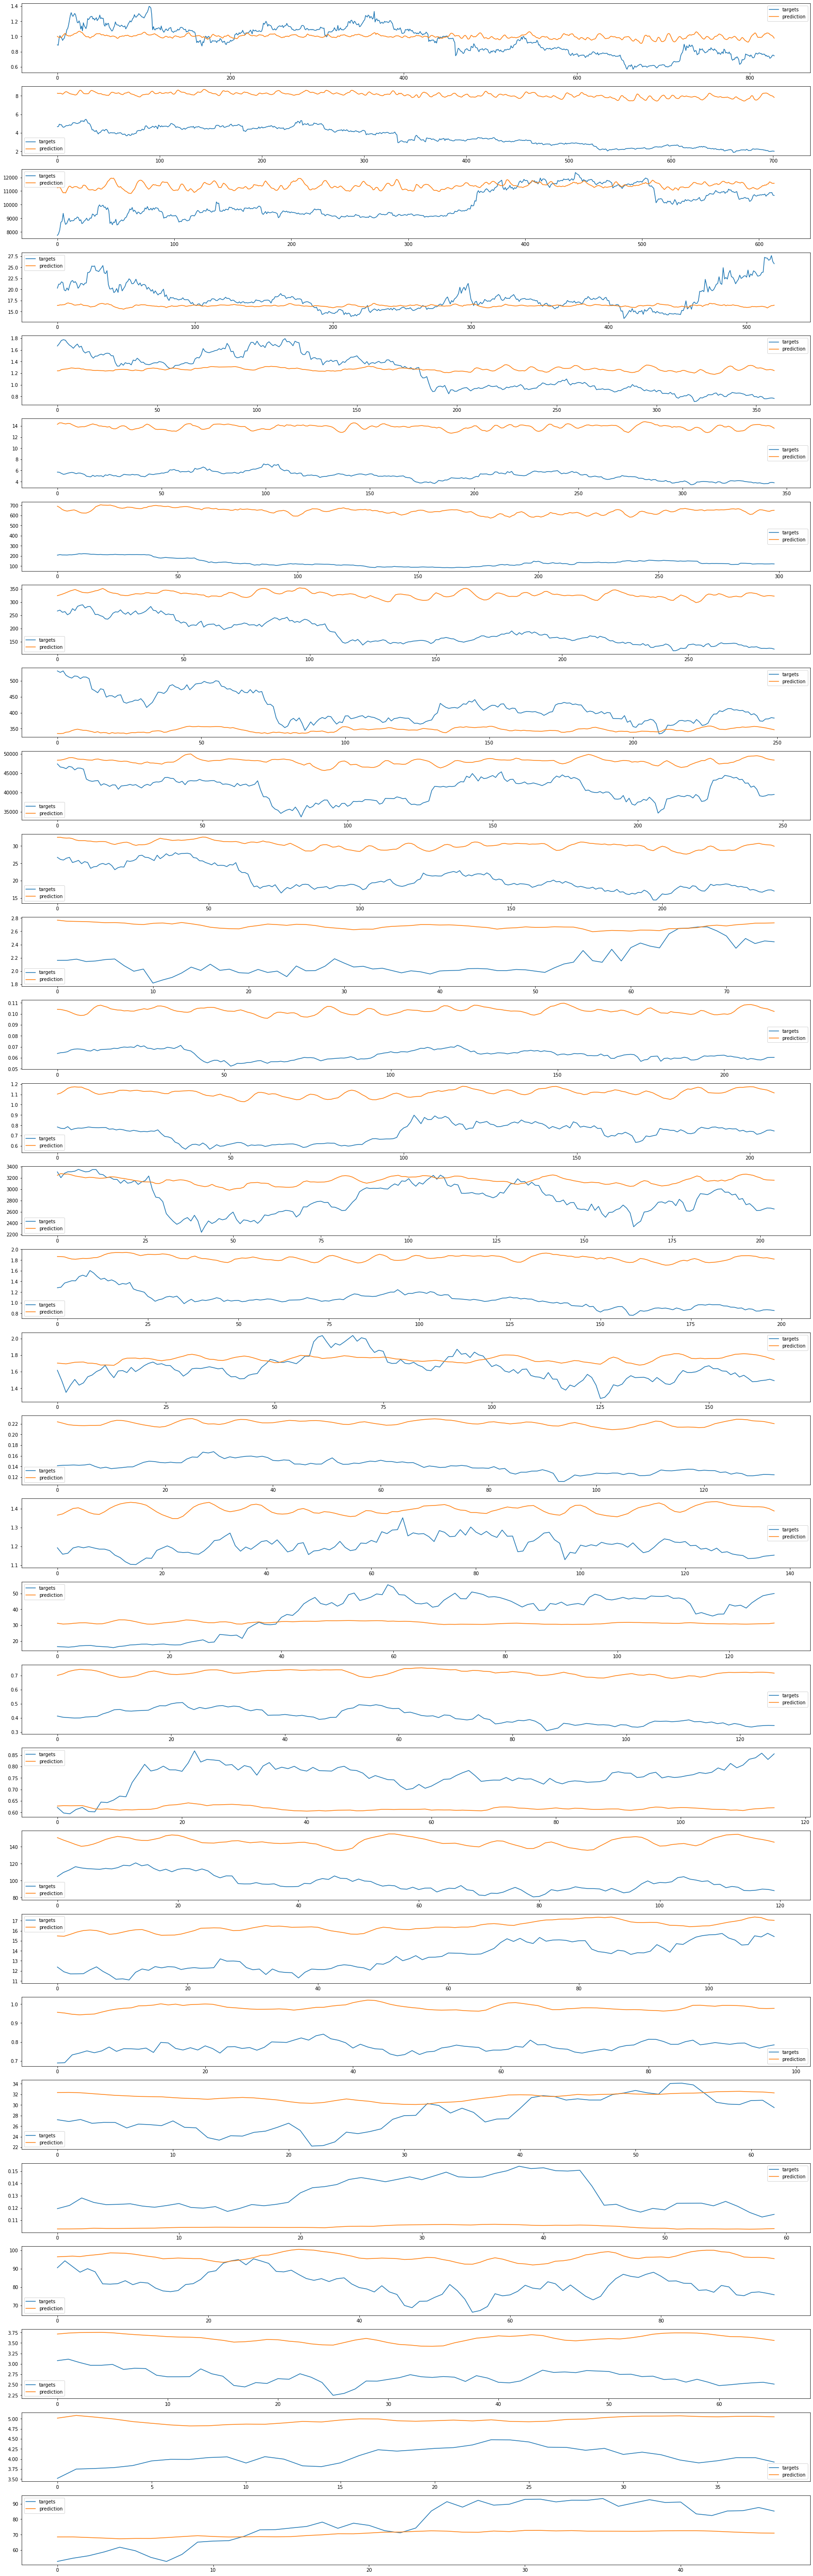

In [8]:
fig, axs = plt.subplots(len(test_datasets), figsize=(30, 100))
tf.config.run_functions_eagerly(True)
for index, (scaler, test_dataset) in enumerate(dm.test_datasets):
    # print(list(test_dataset.as_numpy_iterator()))
    prediction = wgan.generator.predict(test_dataset)
    closes = []
    for _, _, close in test_dataset:
        closes.append(close)
    targets = scaler.inverse_transform(
        np.squeeze(np.concatenate(closes)).reshape(-1, 1)
    )
    predictions = scaler.inverse_transform(np.squeeze(prediction).reshape(-1, 1))
    axs[index].plot(targets, label="targets")
    axs[index].plot(predictions, label="prediction")
    axs[index].legend()


In [ ]:
run.finish()
